# Afternoon: Introduction to Spatial Analysis
Now that we've learned the basics of autocorrelation, we're ready to extend the concept to multiple dimensions. We'll see that spatial dimensions are a direct generalization of temporal dimension, and the concept of $lag$ carries over analogously. 

The first thing we do is remove the previous workspace and load the required packages

In [2]:
rm(list=ls())
library(nlme)                              #package to fit statistical models with autocorrelation
library(fields)                            #package for nice image plots
library(geoR)                              #package to fit spatial variograms
library(colorRamps)                        #package for custom R colors
rmat90 <- function(x) t(apply(x, 2, rev))  #function to rotate a matrix 90 degrees for plotting

## Simulate spatially correlated data
Here we use an exponential covariance matrix which closely approximates the autoregressive model. We do this because it is more commonly used in software packages for numerical reasons. The approximation is $\alpha \approx e^{-r}$, where $r$ is referred to as the 'decorrleation parameter'. 

In [12]:
M  	<- expand.grid(1:30, 1:30)  #two column matrix with all pair-wise coordinates
n  	<- nrow(M)                  #number of pairs
D  	<- as.matrix(dist(M))       #compute pair-wise distances
r  	<- 0.1                      #decorrelation parameter
s  	<- 10                       #variance
S 	<- s^2*exp(-r*D)            #construct covariance matrix based on distance
L  <- chol(S)                   #Cholesky factorization of the covariance matrix
Si <- chol2inv(L)               #use factorization to efficiently find inverse of covariance
Li <- solve(L)                  #inverse of the triangular matrix

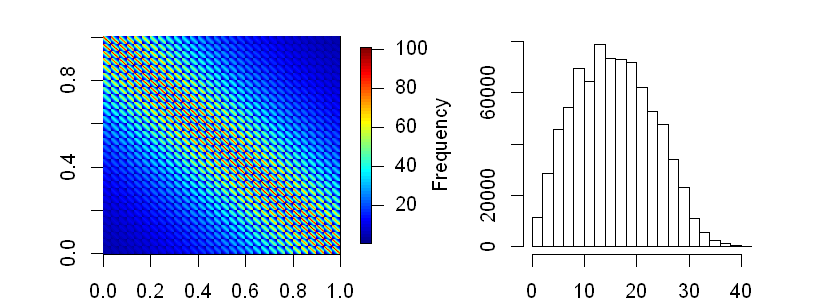

In [15]:
options(repr.plot.width=7, repr.plot.height=2.5)
par(mfrow=c(1,2))
image.plot(rmat90(S))       #visualize the covariance matrix
hist(c(D))                  #make a histogram of the pair-wise distances

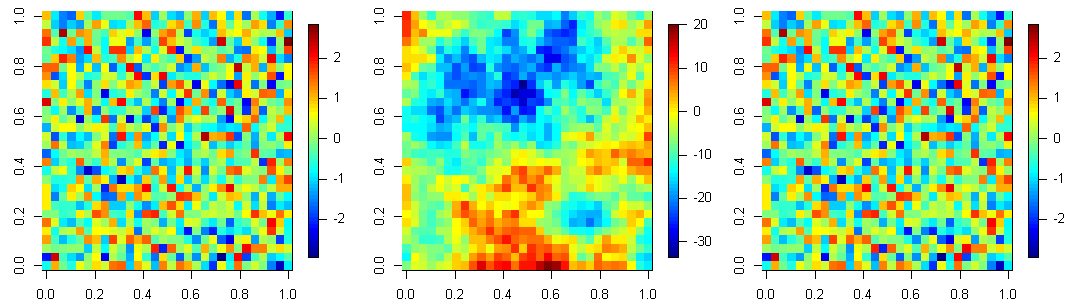

In [27]:
x0  <- matrix(rnorm(n), ncol=n)
x   <- x0%*%L                    #transform the random data by the factored covariance matrix to generate spatial correlation
x00 <- x%*%Li                    #transform back to random data by multiplying by the inverse of the factored covariance matrix

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(5,2,2,2))
image.plot(as.matrix(xtabs(t(x0)  ~ M[,1] + M[,2])))   #use xtabs() to fill in matrix elements with dimensions M[,1] and M[,2] 
image.plot(as.matrix(xtabs(t(x)   ~ M[,1] + M[,2])))
image.plot(as.matrix(xtabs(t(x00) ~ M[,1] + M[,2])))

## Spatial Interpolation

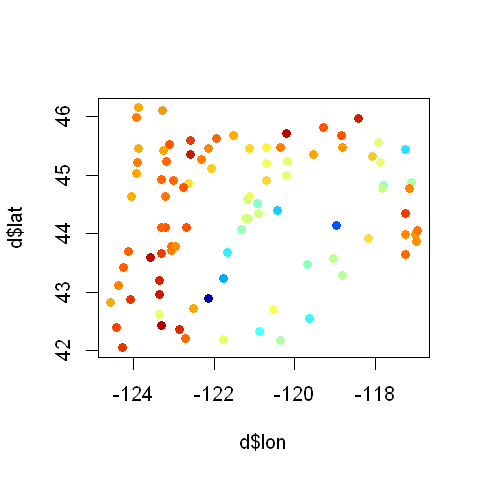

In [3]:
d <- read.csv('../Data/oregon_temp_precip.csv',header=TRUE,stringsAsFactors=FALSE)  #read the data from your local repository  
cols <- matlab.like(100)[as.numeric(cut(d$temp_annual,breaks=100))]  #set point colors according to value of third variable
options(repr.plot.width=4, repr.plot.height=4)                       #parameters for Jupyter plot window
plot(d$lon,d$lat,col=cols,pch=19)                                    #scatterplot with point colors

In [4]:
y      <- d$temp_annual                #variable to interpolate
latlon <- cbind(d$lon,d$lat)           #create matrix with coordinates
s_obs  <- 2                            #fix the assumed measurement error (not necessary, but speeds up optimization)
fit <- likfit(data=y,coords=latlon,    #use command from geoR to optimize the variogram parameters
	fix.nugget=TRUE,                   #nuggest is the same as measurement error
	cov.model="exponential",           #specify functional form for the autocorrelation/autocovariance function
	ini=c(30,5),                       #initial values for the optimizer
	nugget=s_obs,                      #fix the nugget for speed
	lik.method = "ML")                 #maximize the exact likelihood (good for model selection stuff)
phi_hat <- fit$cov.pars[2]             #extract the optimized parameters
s2_hat <- fit$cov.pars[1]              

kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optim.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optim.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.


In [6]:
lon0    <- seq(min(latlon[,1]),max(latlon[,1]),length=100)      #points where to generate interpolated values
lat0    <- seq(min(latlon[,2]),max(latlon[,2]),length=100)    
latlon0 <-expand.grid(lon0,lat0)                                #individual location
pred <- krige.conv(data=y,                                      #function to generate prediction, given a particular variogram
				   coords=latlon,                               #command recognizes latitude/longitude values (very nice feature!)
				   locations=latlon0,                           #input latitudes and longitudes
				   krige=krige.control(cov.model="exponential", #specify the optimized variogram functional form
				   cov.pars=c(s2_hat,phi_hat),nugget=s_obs))    #input optimized variogram parameters

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


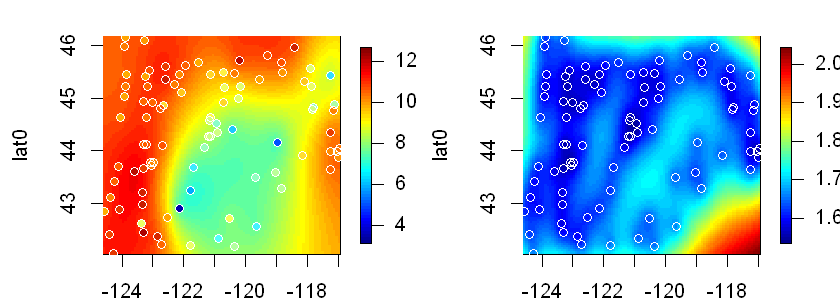

In [8]:
options(repr.plot.width=7, repr.plot.height=2.5)
par(mfrow=c(1,2))	
image.plot(lon0,lat0,matrix(pred$predict,100,100),zlim=range(y))   #plot the interpolated values
	cols <- matlab.like(100)[as.numeric(cut(y,breaks=100))]        #specify colors
	points(latlon,col=cols,pch=19)                                 #add observations as points
	points(latlon,col='white')                                     #give them a white outline to see them easily
image.plot(lon0,lat0,matrix(sqrt(pred$krige.var),100,100))         #plot the confidence interval for the prediction; note that this is conditional on the particular values of the parameters so does not capture 100% of the uncertainty; the package has more complex functionality to incorporate this  
points(latlon,col='white')                                         #white outline for point location

## Spatial regression

In [27]:
d[1:3,]      #display the top three rows of the dataset

station,lat,lon,elevation,temp_jan,temp_jul,temp_annual,precip_jan,precip_jul,precip_ann,county
ANT,44.917,-120.717,846,0.0,20.2,9.6,41,9,322,ANTELOPE 1 N USA-OR
ARL,45.717,-120.200,96,0.9,24.6,12.5,40,6,228,ARLINGTON USA-OR
ASH,42.217,-122.717,543,3.1,20.8,11.1,70,7,480,ASHLAND 1 N USA-OR


In [25]:
fit <- gls(precip_ann ~ temp_annual, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')  #fit linear regression model while account for spatial autocorrelation 
summary(fit)    #print a summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: d 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual

In [28]:
fit2 <- gls(precip_ann ~ temp_annual + elevation, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')   #fit regression model to two parameters
summary(fit)     #summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: d 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual

In [29]:
y      <- predict(fit2)              #extract the 'fitted values' from the regression
latlon <- cbind(d$lon,d$lat)         #matrix of observation locations 
fit <- likfit(data=y,coords=latlon,  #function to optimize the variogram with respect to the predictions
	fix.nugget=TRUE,                 #fix the observation error so it runs more quickly
	cov.model="exponential",         #specify functional form for the variogram
	ini=c(30,5),                     #initial value  for the variogram parameters
	nugget=s_obs,                    #specify the nugget value 
	lik.method = "ML") 
phi_hat <- fit$cov.pars[2]           #extract the optimized variogram parameters
s2_hat <- fit$cov.pars[1]            

lon0    <- seq(min(latlon[,1]),max(latlon[,1]),length=100)       #coordinates where to make predictions
lat0    <- seq(min(latlon[,2]),max(latlon[,2]),length=100)
latlon0 <-expand.grid(lon0,lat0)                                 #individual sets of coordinates
pred <- krige.conv(data=y,                                       #function to generate predictions
				   coords=latlon,                                #recognize coordinates as latitude and longitude
				   locations=latlon0,                            #input coordinates
				   krige=krige.control(cov.model="exponential",  #functional form for input variogram
					cov.pars=c(s2_hat,phi_hat),nugget=s_obs))    #input variogram parameters from optimization

kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optimize.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optimize.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.
krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


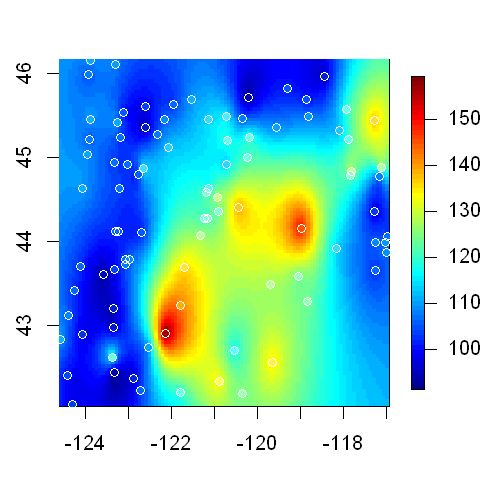

In [32]:
image.plot(lon0,lat0,matrix(pred$predict,100,100),zlim=range(y))   #plot the matrix of values
	cols <- matlab.like(100)[as.numeric(cut(y,breaks=100))]        #colorbar for observations
	points(latlon,col=cols,pch=19)                                 #add observations with coors
	points(latlon,col='white')                                     #give them a white outline

## Model selection

In [69]:
dat <- data.frame(y=as.numeric(y),x=as.numeric(x),lat=M[,1],lon=M[,2])                   #create data.frame of values to pass to model fit
fit1 <- gls(y ~ x, data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')  #fit the regression with exponential covariance matrix
fit2 <- gls(y ~ x, data=dat, correlation=corGaus(form=~lat+lon,nugget=TRUE),method='ML') #fit the regression with Gaussian covariance matrix
BIC(fit1,fit2)                                                                           #display the Bayesian Information Criterion of the fits   

,df,BIC
fit1,5,2595.148
fit2,5,2594.848


In [70]:
dat <- data.frame(y=as.numeric(y),x=as.numeric(x),x2=as.numeric(x^2),lat=M[,1],lon=M[,2])       #create data.frame of values to pass to model fit
fit1 <- gls(y ~ x,      data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')    #fit the single regression with exponential covariance matrix
fit2 <- gls(y ~ x + x2, data=dat, correlation=corExp(form=~lat+lon,nugget=TRUE),method='ML')    #fit a two variable regression with exponential covariance matrix 
BIC(fit1,fit2)                                                                                  #display the Bayesian information crtierion of the fits

,df,BIC
fit1,5,2595.148
fit2,6,2601.789
